This code was used to learn how the VQC worked using Qiskit from a Qiskit tutorial.

In [24]:
# This code defines the images to be classified:
 
import numpy as np
 
# Total number of "pixels"/qubits
size = 8
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2
 
 
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))
 
    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1
 
    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.
 
    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1
 
    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.
 
    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
 
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.
 
        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels
 
 
hor_size = round(size / vert_size)

In [25]:
from sklearn.model_selection import train_test_split
 
np.random.seed(42)
images, labels = generate_dataset(200)
 
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

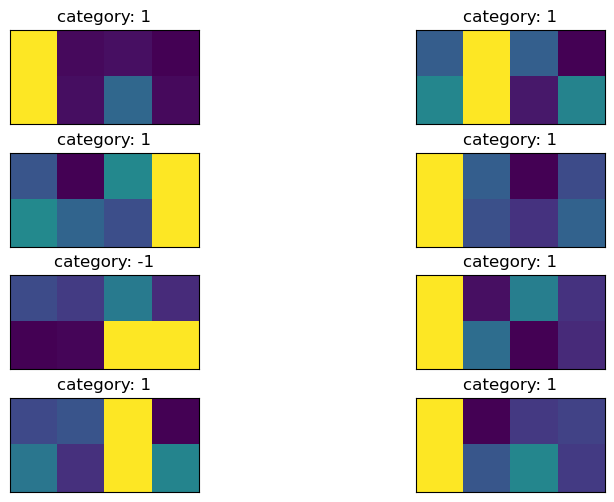

In [26]:
import matplotlib.pyplot as plt
 
# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = "category: " + str(train_labels[i])
    titles.append(title)
 
# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
 
for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [27]:
from qiskit.circuit.library import ZFeatureMap
 
# One qubit per data feature
num_qubits = len(train_images[0])
 
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = ZFeatureMap(num_qubits, parameter_prefix="a")

/var/folders/wz/lbx10qps1tdc1npmd3kbq2t00000gn/T/ipykernel_2199/2222769388.py:8: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(num_qubits, parameter_prefix="a")


5
2+ qubit depth: 3


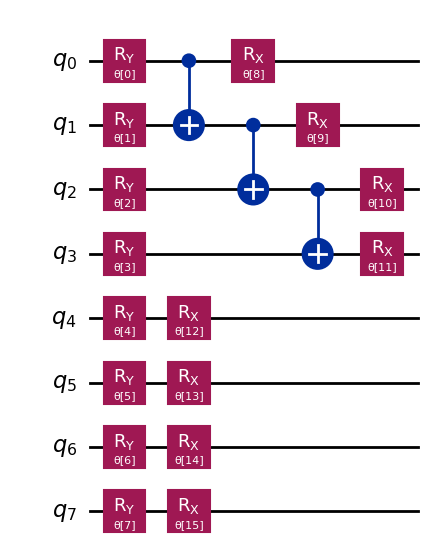

In [28]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
 
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Draw the circuit
qnn_circuit.draw("mpl")

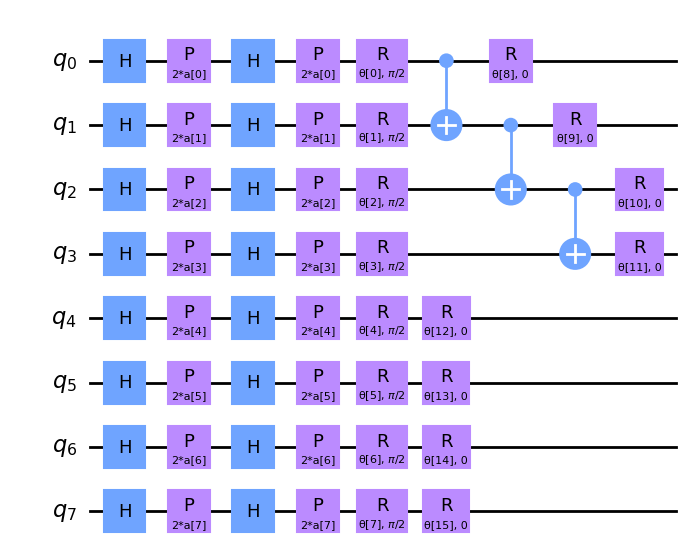

In [29]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [30]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

In [31]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
 
 
def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

In [32]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

In [33]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost

In [34]:
from scipy.optimize import minimize

In [35]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

In [36]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

IBMInputValueError: 'No matching instances found for the following filters: .'

In [42]:
backend = AerSimulator().from_backend(FakeSherbrooke())

In [43]:
print(backend.name)

aer_simulator_from(fake_sherbrooke)


In [44]:
backend = AerSimulator().from_backend(FakeSherbrooke())
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target

pm = generate_preset_pass_manager(
    target=target,
    optimization_level=3,
    routing_method="basic",          # avoids routing plugin
    layout_method="trivial",         # avoids layout plugin
    translation_method="translator", # avoids translation plugin ("unroller" also works)
    scheduling_method=None           # you schedule below
)

pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)


In [45]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

In [46]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0002309063537163
Iter: 50, loss: 0.9910034423915879


In [47]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[-1.07806742e-01  6.13858034e-02  4.88889517e-01 -5.41712363e-03
  2.31673659e-02 -6.35621634e-02 -2.93639980e-02 -1.16960293e-01
 -2.27045285e-01  3.47143847e-02 -4.34058731e-02  6.85959275e-02
  8.84012236e-04  2.27796482e-02 -3.47623501e-01  2.83825760e-02
 -3.47907576e-02 -1.45786585e-01 -4.69533007e-01 -1.82567961e-02
  1.28817243e-02 -1.21096334e-01 -3.91629501e-02 -3.22499359e-02
 -3.00525480e-03  3.64481144e-01  3.46037115e-02  5.12956201e-02
  4.50301723e-02  4.60529753e-03  4.05152080e-01 -8.78057641e-03
  6.60525998e-02  9.46294901e-02 -6.25719669e-02  3.41390986e-02
  2.40935012e-01  5.01122603e-02 -1.84654103e-02 -4.29890934e-01
 -2.89662767e-01  9.80257522e-02  1.74880477e-03  2.70065669e-02
  2.78388953e-01 -3.71069404e-01 -9.35074411e-03 -2.40493738e-02
  1.91052334e-02  6.61345076e-02  2.26706244e-03  2.32049920e-01
  6.98402216e-02 -2.75758526e-01  9.08902060e-03 -1.66811583e-02
  4.50958752e-03 -5.04659680e-02 -1.31891331e-03 -1.40589079e-02
 -1.07686363e-02  2.85093

In [48]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)
 
print(pred_test)
 
pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)
 
accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[ 0.03490544  0.03185024 -0.03818344  0.25266111  0.00792563 -0.51590529
 -0.02111715 -0.15116484  0.04626771  0.02426528  0.04657796 -0.03113558
  0.02293938  0.19400836  0.00329491  0.03525167 -0.00349979 -0.1225299
  0.13400674  0.02368346  0.28452681  0.03545407 -0.00502367 -0.10460012
  0.10591551  0.06649062 -0.05393373 -0.02300524  0.0056465  -0.09439755
  0.06771526 -0.07226252 -0.10675784 -0.01806446  0.00150743  0.1720385
 -0.14832903  0.03214366 -0.05805016 -0.00734088 -0.08244864 -0.01978241
  0.16975198 -0.02933303 -0.0082598  -0.01845949  0.19266379  0.17243566
 -0.02712035  0.02130188 -0.25076566  0.0100313  -0.10234677 -0.09672355
  0.04818503 -0.01241683  0.2933495  -0.02171279 -0.00102982 -0.01206131]
[ 1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1. -1. -1.
  1. -1.  1. -1. -1. -1.]
[-1, -1, 1, 1, -1, -1, 1, 

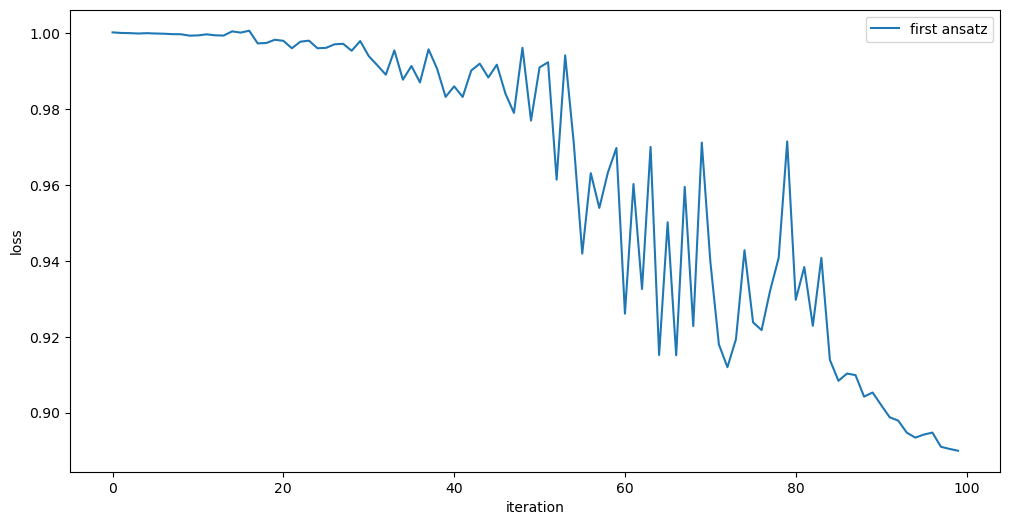

In [49]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [50]:
missed = []
for i in range(len(test_labels)):
    if pred_test_labels[i] != test_labels[i]:
        missed.append(test_images[i])
print(len(missed))

24


5
2+ qubit depth: 3


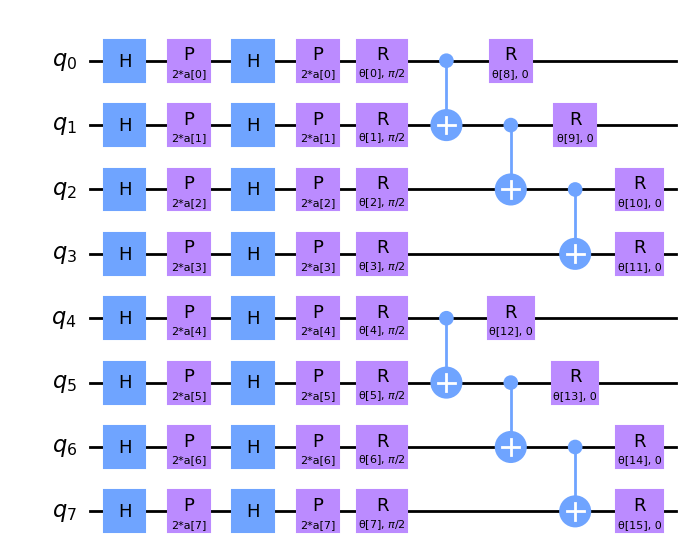

In [52]:
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is an extended list of qubit pairs between which we want CNOT gates. This now covers all pixels connected by horizontal lines.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3], [4, 5], [5, 6], [6, 7]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Combine the feature map and variational circuit
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [53]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0049762969140237
Iter: 50, loss: 0.9610166111578138


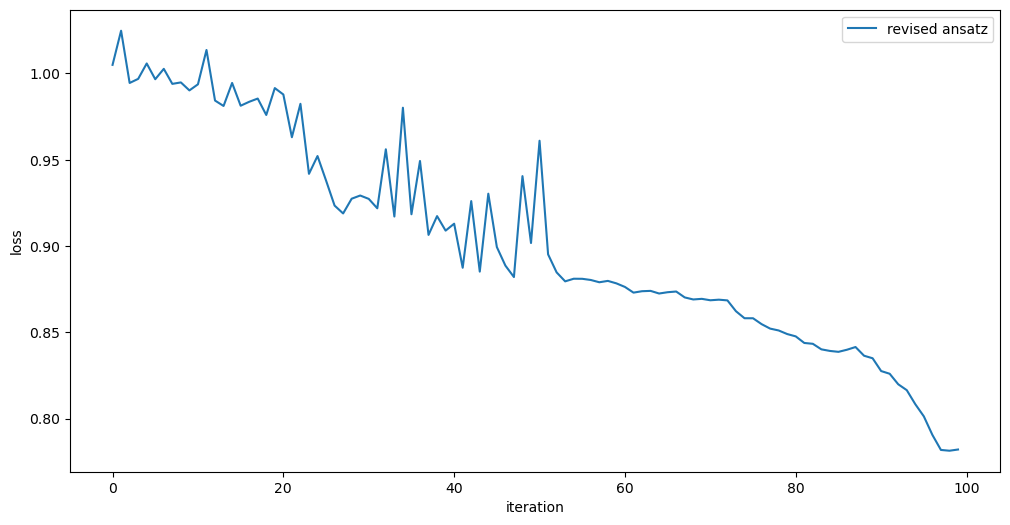

In [54]:
obj_func_vals_revised = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_revised, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.17588365  0.06358946  0.03154715  0.40568015 -0.26663654  0.35052378
  0.32532118  0.42179424 -0.12503935  0.01735073  0.34210006  0.03982966
  0.22643087 -0.4412831  -0.08404207 -0.21145139 -0.0864077  -0.08422211
  0.1610014   0.16197725  0.40828044 -0.14028519  0.12610441  0.33568985
 -0.21658925  0.14599275  0.2047188   0.27508696  0.38082561 -0.07229336
  0.01794865  0.29048418 -0.10297829  0.12442964  0.38024615  0.17366051
  0.06349612  0.27704119 -0.13239334 -0.02905743  0.03690951  0.18908208
  0.31179867 -0.45557033  0.0577176  -0.10626097  0.28010561  0.23700008
 -0.16567916  0.15686607  0.12601319  0.23702745  0.12737872 -0.14154204
  0.13267215  0.39800623  0.03006156  0.46442971 -0.21106578 -0.34238585
 -0.10174681  0.21789043  0.08702818 -0.1833671   0.32475031  0.2210001
  0.38867033 -0.10543421  0.09170983  0.45790369  0.09308404  0.2297307
  0.38493105  0.3522148  -0.03609128  0.0977109   0.20883459  0.07064556
  0.18794959  0.16861158  0.30113559  0.45925807  0.4